imports

In [162]:
import re
import time
from collections import Counter

import pandas as pd
import missingno as msno
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [163]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/eya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/eya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

La requête SQL utilisée pour télécharger le fichier CSV à partir de l'API Stack Exchange



    SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount
    FROM Posts
    WHERE PostTypeId = 1  
    AND Score > 5 AND AnswerCount > 0 
    AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5
    AND AnswerCount > 0
    AND ViewCount > 10


In [164]:
df = pd.read_csv(f'query.csv')

In [165]:
df.shape

(50000, 8)

In [166]:
df.head(5)

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,19,352,70491,0.0,23
1,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,25,176,16433,0.0,9
2,.Net XML comment into API Documentation,<p>Is there an easy way to produce MSDN-style ...,<visual-studio><xslt><documentation><sandcastl...,855,21,3499,0.0,6
3,Linux shell equivalent on IIS,<p>As a LAMP developer considering moving to a...,<windows><iis><shell><command-line><terminal>,1584,21,3507,NaN,8
4,Mechanisms for tracking DB schema changes,<p>What are the best methods for tracking and/...,<php><mysql><database><svn><migration>,1607,139,44980,0.0,20


Récupération des 3 features : **Title**, **Body**, **Tags**

In [167]:
df = df[['Title', 'Body', 'Tags']]

In [168]:
df.head(5)

,Title,Body,Tags
0,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...
1,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>
2,.Net XML comment into API Documentation,<p>Is there an easy way to produce MSDN-style ...,<visual-studio><xslt><documentation><sandcastl...
3,Linux shell equivalent on IIS,<p>As a LAMP developer considering moving to a...,<windows><iis><shell><command-line><terminal>
4,Mechanisms for tracking DB schema changes,<p>What are the best methods for tracking and/...,<php><mysql><database><svn><migration>


<Axes: >

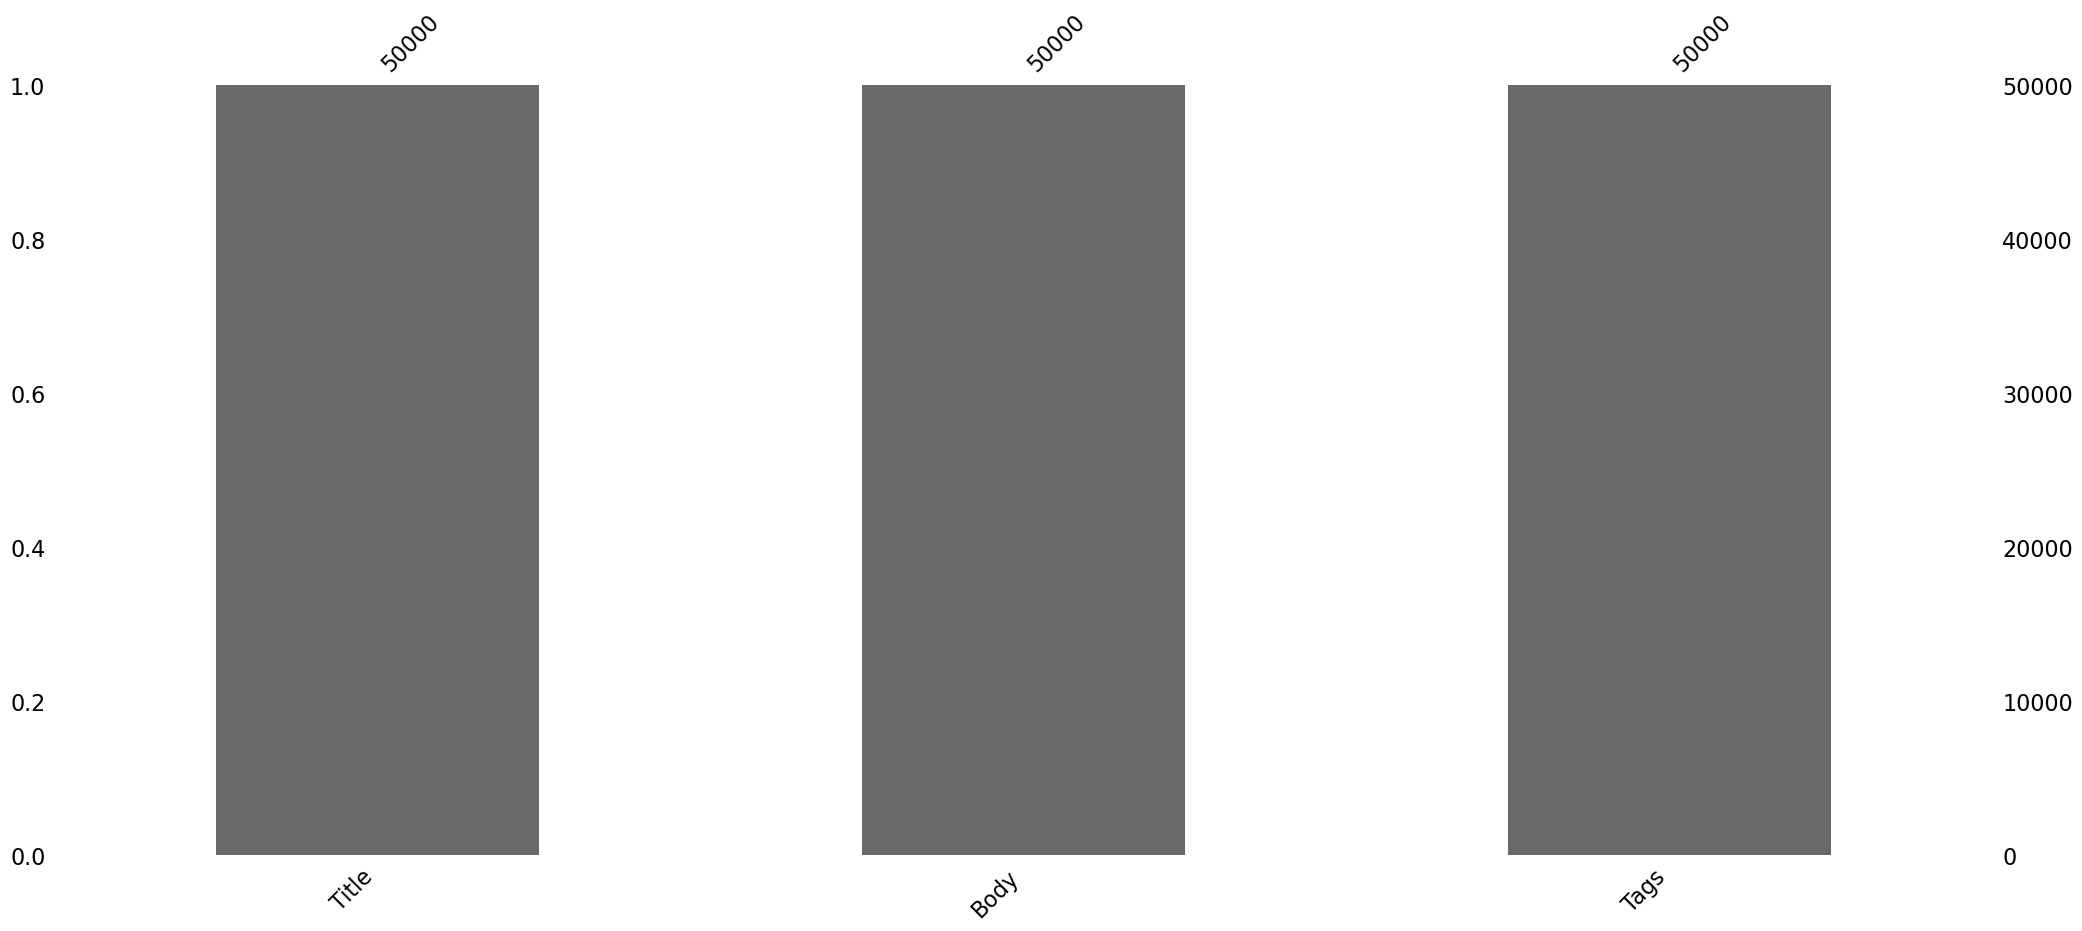

In [169]:
# Visualise missing data
msno.bar(df)

Pas de valeurs nulles dans le dataframe

In [170]:
cleaned_df = df.copy()  # Copy the dataframe to avoid modifying the original

    

##### Nettoyage du texte

Nettoyage des Questions :
- Suppression des balises HTML.
- Conversion des caractères en minuscules.
- Suppression des caractères de ponctuation.
- Suppression des stopwords (mots courants qui n'apportent pas beaucoup de sens).

Nettoyage des Tags :
- Suppression des < et >.
- Supression des Tags qui apparaissent mois de 100 fois

Supression des balises html de la colonne Body

In [171]:
cleaned_df['Body'] = cleaned_df['Body'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

Supression des < et > de la colonne Tags

In [172]:
def clean_tags(tags_string):
    # Remove the angle brackets and split the string by '><'
    tags_list = tags_string.strip('<>').split('><')
    
    # Joins the elements of the input list into a single string
    text = ' '.join(tags_list)
    return text


In [173]:
# Apply the transformation function to the 'tags' column
cleaned_df['Tags'] = cleaned_df['Tags'].apply(clean_tags)

In [174]:
cleaned_df.head(5)

,Title,Body,Tags
0,What is the fastest way to get the value of π?,I'm looking for the fastest way to obtain the ...,performance algorithm language-agnostic unix pi
1,How to use the C socket API in C++ on z/OS,I'm having issues getting the C sockets API to...,c++ c sockets mainframe zos
2,.Net XML comment into API Documentation,Is there an easy way to produce MSDN-style doc...,visual-studio xslt documentation sandcastle xm...
3,Linux shell equivalent on IIS,As a LAMP developer considering moving to a .N...,windows iis shell command-line terminal
4,Mechanisms for tracking DB schema changes,What are the best methods for tracking and/or ...,php mysql database svn migration


Fusionner les 2 colonnes **Title** et **Body** en une seule colonne **Question**

In [175]:
cleaned_df['Question'] = cleaned_df['Title'] + ' ' + cleaned_df['Body']


In [176]:
cleaned_df = cleaned_df[['Question', 'Tags']]

In [177]:
cleaned_df.sample(5)

,Question,Tags
17577,"AWS EMR perform ""bootstrap"" script on all the ...",python amazon-web-services boto emr amazon-emr
45153,Android Studio - checkout a *branch* from GitH...,android git android-studio github intellij-idea
1171,How can I use Linq with a MySql database on Mo...,c# mysql linux linq mono
34893,Use another control as an opacity mask in WPF?...,wpf controls transparency opacity mask
11279,Prevent UICollectionView from animating during...,ios swift swift3 uicollectionview collectionview


In [178]:
def clean_text(text):
    """
    Supprime la ponctuation, les chiffres et les caractères spéciaux, sauf 'c++' et 'c#'
    """
    # Remplace 'c++' et 'c#' dans le texte
    text = re.sub(r'\bc\+\+\b', 'cpp', text)
    text = re.sub(r'\bc#\b', 'csharp', text)
    # Supprimer la ponctuation, les chiffres et les caractères spéciaux, sauf les motifs spécifiques
    text = re.sub(r'(?<!_)(?<!_)_{3,}(?!_)(?!_)', ' ', text)  # Supprimer les motifs '___', '____', etc.
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'_+', ' ', text)
    return text


In [179]:
def lowercase_text(text):
    """
    Convertit un texte en minuscules.
    """
    return text.lower()

In [180]:
def preprocess_text(text):
    """
    Converti en minuscules et supprime les mots vides et les mots courts
    """
    text = lowercase_text(text)  # Convertir en minuscules
    text = clean_text(text)  # Supprimer la ponctuation et les chiffres
    tokens = word_tokenize(text)  # Tokenisation des mots
    stop_words = set(stopwords.words('english'))  # Liste des mots vides en anglais
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  # Supprimer les mots vides et les mots courts
    lemmatizer = WordNetLemmatizer()  # Initialiser le lemmatiseur
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatisation des mots
    return ' '.join(tokens)

In [181]:
# Appliquer la fonction de prétraitement au texte de la colonne "question"
cleaned_df['Question'] = cleaned_df['Question'].apply(preprocess_text)

In [182]:
def remove_non_latin_letters(text):
    # Utiliser une expression régulière pour ne garder que les lettres de l'alphabet latin
    latin_only_text = re.sub(r'[^a-zA-Z]', ' ', text)
    return latin_only_text

In [183]:
def remove_words_with_repeated_letters(text):
    # Utiliser une expression régulière pour trouver les mots avec la même lettre répétée trois fois ou plus
    filtered_text = re.sub(r'\b\w*(\w)\1{2,}\w*\b', ' ', text)
    return filtered_text


In [184]:
cleaned_df['Question'] = cleaned_df['Question'].apply(remove_non_latin_letters)

In [185]:
cleaned_df['Question'] = cleaned_df['Question'].apply(remove_words_with_repeated_letters)

In [186]:
cleaned_df.head(5)

,Question,Tags
0,fastest way get value looking fastest way obta...,performance algorithm language-agnostic unix pi
1,use socket api issue getting socket api work p...,c++ c sockets mainframe zos
2,net xml comment api documentation easy way pro...,visual-studio xslt documentation sandcastle xm...
3,linux shell equivalent ii lamp developer consi...,windows iis shell command-line terminal
4,mechanism tracking schema change best method t...,php mysql database svn migration


In [187]:
# Définir display.max_colwidth sur 1 pour afficher toutes les colonnes entièrement
pd.set_option('display.max_colwidth', 1)

In [188]:
# Afficher la ligne 49995 du DataFrame cleaned_df
cleaned_df.iloc[[49995]]

,Question,Tags
49995,java converting object subclass code scene java different type object included one common arraylist called target share tostring method return identifier want use target list determine object scene match given identifier regardless type arraylist npc npc new arraylist npc arraylist item item new arraylist item arraylist enviromentalobject enviromental object new arraylist enviromentalobject arraylist object target public object check target string target name target addall npc target addall item target addall enviromental object object target target target tostring target name return target return null code game java check given identifier match ion current scene want know object type treat true type right following code knew work maybe help get idea across object target current scene check target target name target null system println unrecognized target message else string target type target getclass getname target target type target would correct way getting object type able use object method right given object method create superclass npc item enviromentalobject,java class oop inheritance types


In [189]:
df_49995 = cleaned_df.iloc[[49995]]

In [190]:
# Réinitialiser display.max_colwidth à sa valeur par défaut
pd.reset_option('display.max_colwidth')

# EDA

## 1 - Tags

In [191]:
cleaned_df["Tags"].value_counts()

Tags
javascript jquery html css twitter-bootstrap                          22
python image opencv image-processing computer-vision                  20
javascript html css reactjs material-ui                               17
python tensorflow machine-learning keras deep-learning                15
java spring mongodb spring-data spring-data-mongodb                   14
                                                                      ..
database nosql distributed-computing distributed-transactions acid     1
ios swift unit-testing mocking core-bluetooth                          1
python serialization stack continuations python-stackless              1
java networking udp queue rudp                                         1
java performance garbage-collection jvm heap-memory                    1
Name: count, Length: 49129, dtype: int64

In [192]:
# Remplacer les occurrences spécifiques dans la colonne 'Tags'
cleaned_df["Tags"] = cleaned_df["Tags"].replace({"java-8": "java", "python-2.7": "python", "python-3.x": "python"}, regex=True)



In [193]:
def create_corpus(col):
    # Extract titles from the specified column
    titles = cleaned_df[col].tolist()
    
    # Concatenate all titles into a single text string to form the corpus
    corpus = ' '.join(titles)
    
    return corpus


In [194]:
corpusTags = create_corpus('Tags')

In [195]:
corpusTags_list = corpusTags.split(' ')

In [196]:
counts = Counter(corpusTags_list)
token_counts = list(counts.items())

# Trier la liste de tuples en fonction du nombre d'occurrences (de manière décroissante)
token_counts = sorted(token_counts, key=lambda x: x[1], reverse=True)

In [197]:
# Extraire la première colonne (tokens)
tokens = [token for token, _ in token_counts]
cnt = [c for _, c in token_counts]

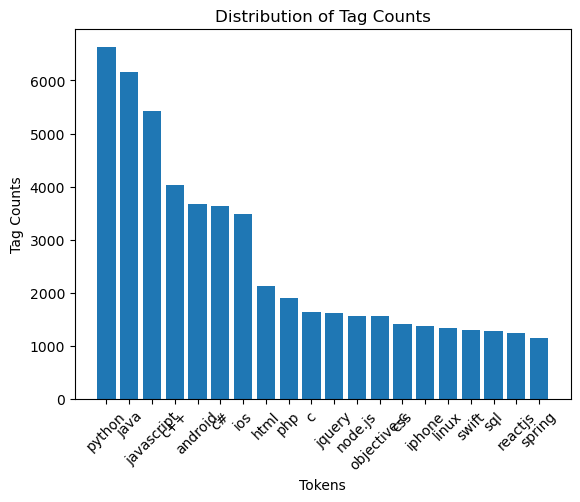

In [198]:
# Tracer le boxplot
plt.bar(tokens[:20], cnt[:20])  # Assigning different colors to each token
plt.xlabel('Tokens')
plt.ylabel('Tag Counts')
plt.title('Distribution of Tag Counts')
# Incliner les étiquettes des tokens sur l'axe des x
plt.xticks(rotation=45)
plt.show()

In [199]:
token_counts[:10]

[('python', 6630),
 ('java', 6154),
 ('javascript', 5422),
 ('c++', 4035),
 ('android', 3675),
 ('c#', 3632),
 ('ios', 3491),
 ('html', 2128),
 ('php', 1901),
 ('c', 1643)]

In [200]:
token_counts[-10:]

[('code-climate', 1),
 ('ruby-2.3', 1),
 ('fdopen', 1),
 ('winscp', 1),
 ('nomenclature', 1),
 ('joda-money', 1),
 ('fsync', 1),
 ('actualwidth', 1),
 ('actualheight', 1),
 ('slidify', 1)]

In [201]:
def count_word_frequency(corpus):
    # Diviser le corpus en mots individuels
    words = corpus.split()

    # Compter le nombre d'occurrences de chaque mot
    word_counts = Counter(words)

    # Nombre total de mots uniques
    unique_word_count = len(word_counts)

    # Nombre total de mots dans le corpus
    total_word_count = len(words)

    # Compter le nombre de mots 
    frequency_counts = Counter(word_counts.values())

    # Afficher les résultats
    print("Nombre total de tags :", total_word_count)
    print("Nombre total de tags uniques :", unique_word_count)
    
    # Calculer le nombre de tags qui apparaissent moins de 500 fois
    less_than_500_count = sum(frequency_counts[frequency] for frequency in range(1, 501))

    # Calculer le pourcentage de ces tags par rapport au nombre total de mots uniques
    percentage_less_than_500 = (less_than_500_count / unique_word_count) * 100

    print(f"Pourcentage de tags qui apparaissent moins de 500 fois : {percentage_less_than_500:.2f}%")
    
    return unique_word_count




In [202]:
nb_unique_tags = count_word_frequency(corpusTags)

Nombre total de tags : 250001
Nombre total de tags uniques : 19051
Pourcentage de tags qui apparaissent moins de 500 fois : 99.74%


In [203]:
def get_most_frequent_tags(corpus, nb_tags):
    # Diviser le corpus en mots individuels
    words = corpus.split()

    # Compter le nombre d'occurrences de chaque mot
    word_counts = Counter(words)

    # Trouver les nb mots les plus fréquents
    top_nb_words = word_counts.most_common(nb_tags)
    
    return top_nb_words

In [204]:
 def show_most_frequent_tags(top_nb_words, nb_tags):  
        
    # Extraire les mots et leurs fréquences
    words = [word_count[0] for word_count in top_nb_words]
    counts = [word_count[1] for word_count in top_nb_words]
    
    # Créer le graphique
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(words)), counts, align='center')
    plt.yticks(range(len(words)), words)
    plt.xlabel('Fréquence')
    plt.ylabel('Mots')
    plt.title(f'les {nb_tags} tags les plus fréquents')
    plt.gca().invert_yaxis()  # Inverser l'ordre des mots
    plt.show() 

In [205]:
top_20_tags = get_most_frequent_tags(corpusTags, 20)

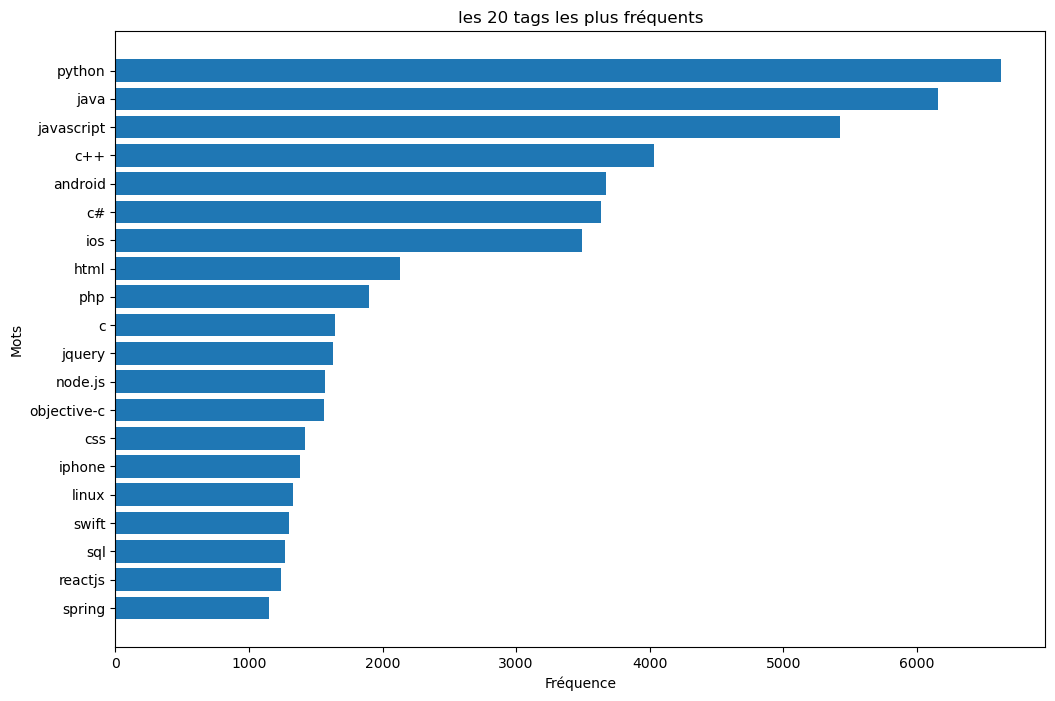

In [206]:
show_most_frequent_tags(top_20_tags, 20)

###### Suppression des Tags qui apparaissent moins de 200 fois

In [207]:
print("Nombre total de tags uniques :", nb_unique_tags)

Nombre total de tags uniques : 19051


In [208]:
# Diviser le texte en mots individuels
corpusTags_words = corpusTags.split()

# Compter le nombre d'occurrences de chaque mot
word_counts = Counter(corpusTags_words)

# Créer une liste des mots à supprimer de la colonne tags (ceux qui apparaissent moins de 500 fois)
tags_to_remove = [word for word, count in word_counts.items() if count < 500]

In [209]:
def remove_tags(text):
    # Diviser le texte en mots individuels
    words = text.split()
    # Filtrer les mots qui ne sont pas dans la liste tags_to_remove
    filtered_words = [word for word in words if word not in tags_to_remove]
    # Rejoindre les mots filtrés pour former le texte final
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [210]:
# Supprimer ces mots de la colonne tags
cleaned_df['Tags'] = cleaned_df['Tags'].apply(lambda x: remove_tags(x))

In [211]:
corpusTags = create_corpus('Tags')

In [212]:
# Diviser le corpus en mots individuels
words = corpusTags.split()

# Compter le nombre d'occurrences de chaque mot
word_counts = Counter(words)

# Nombre total de mots uniques
unique_word_count = len(word_counts)

In [213]:
print("Nombre de tags uniques avant nettoyage :", nb_unique_tags)

# Compter le nombre de mots uniques dans la colonne 'Tags'
print("Nombre de tags uniques aprés nettoyage :", unique_word_count)


Nombre de tags uniques avant nettoyage : 19051
Nombre de tags uniques aprés nettoyage : 49


In [214]:
word_counts

Counter({'python': 6630,
         'java': 6154,
         'javascript': 5422,
         'c++': 4035,
         'android': 3675,
         'c#': 3632,
         'ios': 3491,
         'html': 2128,
         'php': 1901,
         'c': 1643,
         'jquery': 1628,
         'node.js': 1568,
         'objective-c': 1558,
         'css': 1419,
         'iphone': 1382,
         'linux': 1333,
         'swift': 1302,
         'sql': 1272,
         'reactjs': 1238,
         'spring': 1152,
         'xcode': 1096,
         'asp.net': 993,
         'performance': 992,
         'windows': 956,
         'ruby-on-rails': 911,
         'mysql': 895,
         'json': 846,
         'django': 820,
         'sql-server': 799,
         'database': 796,
         'macos': 786,
         'arrays': 785,
         'unit-testing': 763,
         'c++11': 735,
         'ruby': 731,
         'typescript': 729,
         'multithreading': 666,
         'angular': 648,
         'algorithm': 639,
         'string': 630,
   

In [217]:
cleaned_df['Tags'].value_counts()

Tags
                                        6497
java                                    2740
python                                  2593
android                                 2282
c#                                      1841
                                        ... 
java amazon-web-services spring-boot       1
python linux gcc                           1
python performance arrays                  1
node.js multithreading                     1
ruby-on-rails ruby postgresql docker       1
Name: count, Length: 2591, dtype: int64

In [218]:
# Créer une nouvelle colonne contenant le nombre de mots dans la colonne 'tags'
cleaned_df['nb_tags'] = cleaned_df['Tags'].apply(lambda x: len(x.split()))

In [220]:
cleaned_df.head(3)

,Question,Tags,nb_tags
0,fastest way get value looking fastest way obta...,performance algorithm,2
1,use socket api issue getting socket api work p...,c++ c,2
2,net xml comment api documentation easy way pro...,visual-studio,1


In [221]:
cleaned_df['nb_tags'].value_counts()

nb_tags
1    20786
2    16122
0     6497
3     5572
4      954
5       69
Name: count, dtype: int64

Supression des lignes qui ne contiennent aucun tag

In [222]:
# Supprimer les lignes où la colonne 'nb_tags' est égale à zéro
cleaned_df = cleaned_df[cleaned_df['nb_tags'] != 0]

In [223]:
cleaned_df['nb_tags'].value_counts()

nb_tags
1    20786
2    16122
3     5572
4      954
5       69
Name: count, dtype: int64

In [224]:
cleaned_df.shape

(43503, 3)

###### Nuage de mots

In [225]:
def show_wordcloud(listofTags) :
    # Créer un dictionnaire à partir de top_20_words
    word_freq = {tag: freq for tag, freq in listofTags}

    # Créer un nuage de mots à partir du dictionnaire
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Afficher le nuage de mots
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuage de mots des tags')
    plt.show()

In [226]:
corpusTags = create_corpus('Tags')

In [232]:
top_50_tags = get_most_frequent_tags(corpusTags, 50)

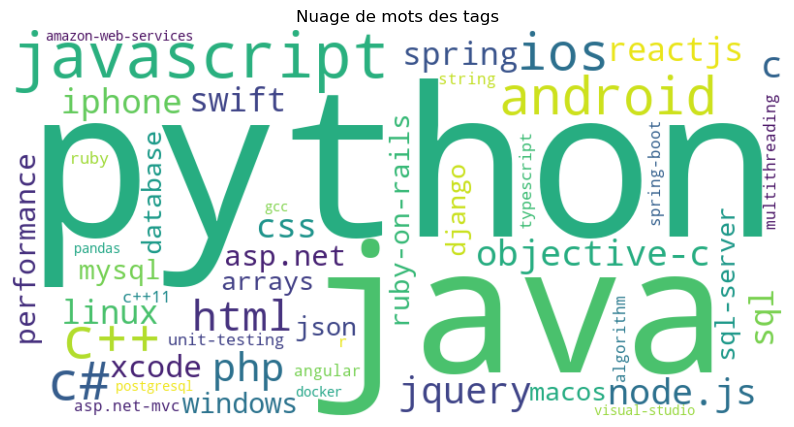

In [233]:
show_wordcloud(top_50_tags)

## 2 - Questions

In [234]:
cleaned_df.shape

(43503, 3)

In [235]:
print(f"Nombre total de questions : {cleaned_df.shape[0]}")


Nombre total de questions : 43503


In [236]:
def get_vocab_questions():
    # Créer une instance de CountVectorizer
    vectorizer = CountVectorizer()

    # Adapter le vectorizer aux données de la colonne 'Tags' et le transformer
    tag_matrix = vectorizer.fit_transform(cleaned_df['Question'])

    # Obtenir le vocabulaire
    vocabulary = vectorizer.vocabulary_
    
    return vocabulary



In [237]:
vocabulary = get_vocab_questions()

In [238]:
# Créer une instance de CountVectorizer avec les paramètres max_df et min_df
vectorizer_question = CountVectorizer(max_df=1.0, min_df=10)

# Adapter le vectorizer aux données de la colonne 'Question' et le transformer
question_matrix = vectorizer_question.fit_transform(cleaned_df['Question'])

# Obtenir les mots (questions) retenus après le filtrage
selected_questions = vectorizer_question.get_feature_names_out()

# Créer un dictionnaire pour mapper les questions retenues aux indices
question_indices = {question: index for index, question in enumerate(selected_questions)}



In [239]:
# Créer une fonction pour filtrer les mots dans chaque ligne de 'Tags'
def filter_words(question):
    filtered_words = []
    for word in question.split():
        if word in question_indices:
            filtered_words.append(word)
        else:
            filtered_words.append('')
    return ' '.join(filtered_words)

Supression des mots qui sont présents dans moins de 5 questions et qui sont présents dans 90% des questions

In [240]:
# Appliquer la fonction de filtrage à chaque ligne de 'Question'
cleaned_df['Question'] = cleaned_df['Question'].apply(filter_words)

/var/folders/g3/n5wwny7s4t74mhr6rr2fwjg40000gn/T/ipykernel_60758/1158685054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Question'] = cleaned_df['Question'].apply(filter_words)


In [241]:
vocabulary_cleaned = get_vocab_questions()

In [242]:
# Afficher la longueur du vocabulaire des Question avant cleaning
print(f"Le vocabulaire des documents contient : {len(vocabulary)}")

Le vocabulaire des documents contient : 179489


In [243]:
# Afficher la longueur du vocabulaire des Question aprés cleaning
print(f"Le vocabulaire des documents contient : {len(vocabulary_cleaned)}")

Le vocabulaire des documents contient : 13668


###### Longueur moyenne des questions : 

In [244]:
# Calculer la longueur de chaque question
cleaned_df['question_length'] = cleaned_df['Question'].apply(lambda x: len(x.split()))


/var/folders/g3/n5wwny7s4t74mhr6rr2fwjg40000gn/T/ipykernel_60758/3170649338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['question_length'] = cleaned_df['Question'].apply(lambda x: len(x.split()))


In [245]:
cleaned_df['question_length'].describe()

count    43503.000000
mean       126.306025
std        156.300148
min          2.000000
25%         49.000000
50%         83.000000
75%        145.000000
max       2885.000000
Name: question_length, dtype: float64

Pas de lignes sans question

In [246]:
# Calculer la longueur moyenne des questions
average_question_length = cleaned_df['question_length'].mean()

print(f"Longueur moyenne des questions : {average_question_length:.2f}")


Longueur moyenne des questions : 126.31


In [247]:
def question_length_dest() :
    # Tracer l'histogramme
    plt.figure(figsize=(8, 6))
    plt.hist(cleaned_df['question_length'], bins=10, color='skyblue', edgecolor='black')
    plt.xlabel('Longueur des questions')
    plt.ylabel('Fréquence')
    plt.title('Distribution de la longueur des questions')
    plt.grid(True)
    plt.show()


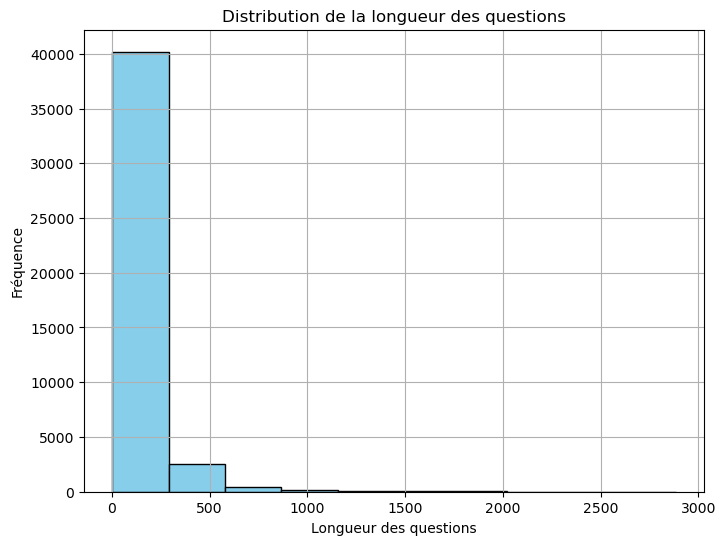

In [248]:
question_length_dest()

###### Visualisation des statistiques descriptives : moyenne, médiane, écart-type des longueur des questions

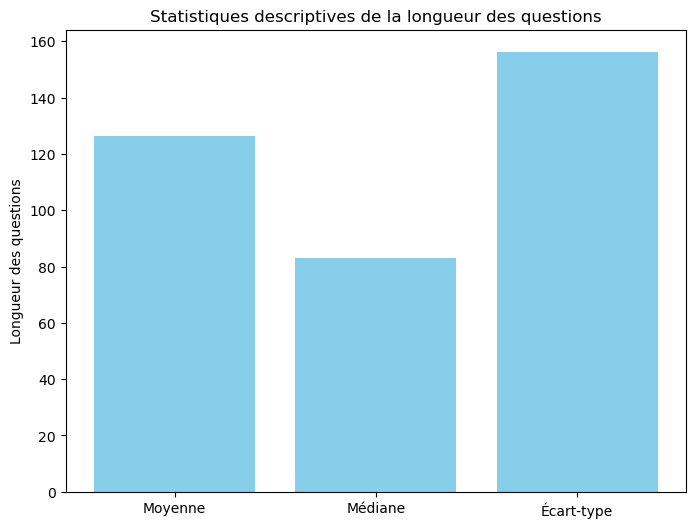

In [249]:
# Calculer les statistiques descriptives
mean_length = cleaned_df['question_length'].mean()
median_length = cleaned_df['question_length'].median()
std_length = cleaned_df['question_length'].std()

# Tracer un diagramme en barres pour les statistiques descriptives
plt.figure(figsize=(8, 6))
plt.bar(['Moyenne', 'Médiane', 'Écart-type'], [mean_length, median_length, std_length], color='skyblue')
plt.ylabel('Longueur des questions')
plt.title('Statistiques descriptives de la longueur des questions')
plt.show()


###### Feature Engineering

### 1 - Questions


FeatureEngineering de type Bag of Words :
   - Construction d'un vocabulaire à partir des mots uniques dans toutes les questions.
   - Transformation des questions en vecteurs de caractéristiques en utilisant la représentation Bag of Words (sac de mots).

Construction d'un vocabulaire à partir des mots uniques dans toutes les questions

In [259]:
corpusQuestion = create_corpus('Question')

Exploration du vocabulaire

In [264]:

# Séparer le texte en une liste de questions
questions = corpusQuestion.split('\n')

# Créer une instance de CountVectorizer
vectorizer = CountVectorizer()

# Adapter le vectorizer aux questions et le transformer en matrice de mots
X = vectorizer.fit_transform(questions)

# Obtenir le vocabulaire (mots uniques) à partir du vectorizer
vocabulary = vectorizer.get_feature_names_out()

# Obtenir la fréquence de chaque mot dans le corpus
word_freq = X.sum(axis=0)

# Trier les mots par fréquence (en ordre décroissant)
sorted_word_freq = sorted(zip(vocabulary, word_freq.flat), key=lambda x: x[1], reverse=True)

# Afficher les 20 mots les plus fréquents
print("Les 20 mots les plus fréquents :")
for word, freq in sorted_word_freq[:20]:
    print(word, freq)




Les 20 mots les plus fréquents :
java 39545
file 37961
class 35129
using 35106
error 32500
android 30817
get 30464
code 28808
data 28296
name 27925
user 26996
new 26447
string 25735
app 25448
return 25187
org 24467
use 24277
like 24205
function 23120
com 22838


In [266]:
vocabulary = get_vocab_questions()

# Afficher le nombre de mots du vocabulaire
print(f"Nombre de mots du vocabulaire : {len(vocabulary)}")

Nombre de mots du vocabulaire : 13668


Transformation des questions en vecteurs de caractéristiques en utilisant la représentation Bag of Words

In [267]:
# Convertir les questions en une liste de chaînes de caractères
questions = cleaned_df['Question'].tolist()

# Initialiser le transformateur BoW
vectorizer = CountVectorizer()

# Adapter le transformateur et transformer les questions en vecteurs de caractéristiques BoW
vecteurs_caracteristiques = vectorizer.fit_transform(questions)

# Afficher la forme de la matrice des vecteurs de caractéristiques
print("Shape of feature vectors matrix:", vecteurs_caracteristiques.shape)

Shape of feature vectors matrix: (43503, 13668)


In [268]:
vecteurs_caracteristiques.data

array([5, 4, 1, ..., 1, 4, 1])

In [269]:
cleaned_df

,Question,Tags,nb_tags,question_length
0,fastest way get value looking fastest way obta...,performance algorithm,2,197
1,use socket api issue getting socket api work p...,c++ c,2,106
2,net xml comment api documentation easy way pro...,visual-studio,1,78
3,linux shell equivalent ii lamp developer consi...,windows,1,26
4,mechanism tracking schema change best method t...,php mysql database,3,114
...,...,...,...,...
49995,java converting object subclass code scene jav...,java,1,145
49996,visual studio breakpoints moved originally use...,c++ visual-studio,2,51
49997,overflow encountered scalar new python first...,python,1,323
49998,could find rake rail docker container running ...,ruby-on-rails ruby postgresql docker,4,154


###### Réduction de Dimension du Vocabulaire et des Tags
       


 Utilisation de techniques comme la TF-IDF (Term Frequency-Inverse Document Frequency) pour pondérer les mots dans les vecteurs de caractéristiques.

In [270]:
# Créer un vecteuriseur TF-IDF pour les questions
tfidf_question = TfidfVectorizer()
tfidf_question.fit(cleaned_df['Question'])
question_vectors = tfidf_question.transform(cleaned_df['Question'])



In [271]:
# Créer un vecteuriseur TF-IDF pour les tags
tfidf_tags = TfidfVectorizer()
tfidf_tags.fit(cleaned_df['Tags'])
tag_vectors = tfidf_tags.transform(cleaned_df['Tags'])

Affichage des matrices TF-IDF

In [272]:
print("Matrice TF-IDF pour les questions :\n", question_vectors.toarray())

Matrice TF-IDF pour les questions :
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [273]:
print("Matrice TF-IDF pour les tags :\n", tag_vectors.toarray())

Matrice TF-IDF pour les tags :
 [[0.         0.73745912 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


###### Affichage des words cloud pour les top 10 tags

In [274]:
top_10_tags = get_most_frequent_tags(corpusTags, 10)

In [275]:
top_10_tags

[('python', 6630),
 ('java', 6154),
 ('javascript', 5422),
 ('c++', 4035),
 ('android', 3675),
 ('c#', 3632),
 ('ios', 3491),
 ('html', 2128),
 ('php', 1901),
 ('c', 1643)]

In [276]:
tags_only = [tag[0] for tag in top_10_tags]
print(tags_only)

['python', 'java', 'javascript', 'c++', 'android', 'c#', 'ios', 'html', 'php', 'c']


In [277]:
# Créer un dictionnaire pour stocker les données de chaque tag
tag_data = {}

# Pour chaque tag dans top_10_tags
for tag in tags_only:
    # Sélectionner les données correspondant aux questions qui contiennent le tag
    tag_questions = cleaned_df[cleaned_df['Tags'].str.contains(str(tag))]['Question']

    
    # Concaténer tous les mots dans les questions associées au tag
    tag_words = ' '.join([' '.join(words) for words in tag_questions.str.split()])
    
    # Compter les occurrences de chaque mot
    word_counts = Counter(tag_words.split())
    
    # Sélectionner les mots les plus fréquents (par exemple, les 50 premiers mots les plus fréquents)
    top_words = word_counts.most_common(50)
    
    # Stocker les données dans le dictionnaire
    tag_data[tag] = top_words


Affichage des word Cloud

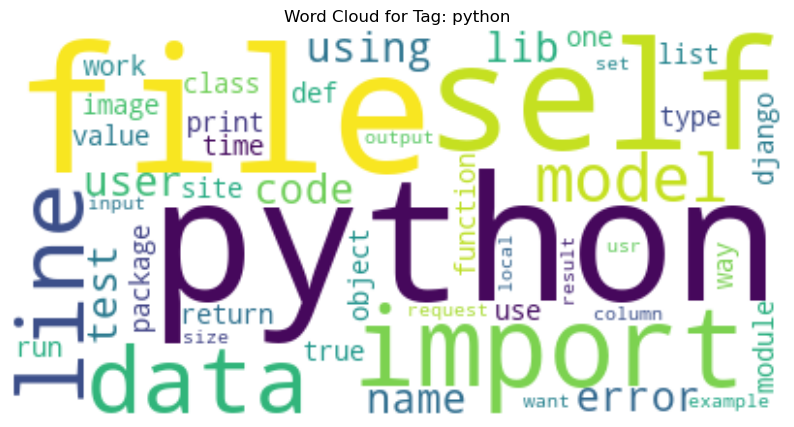

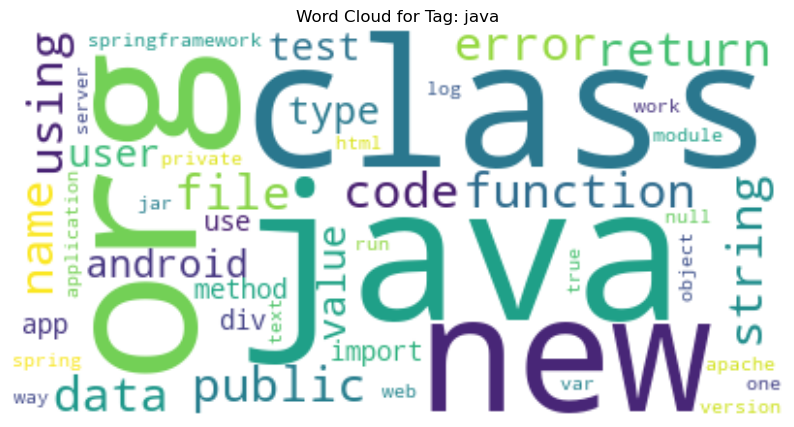

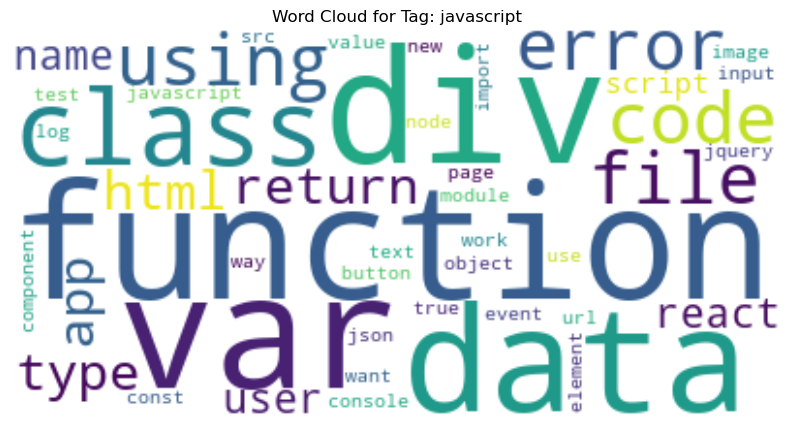

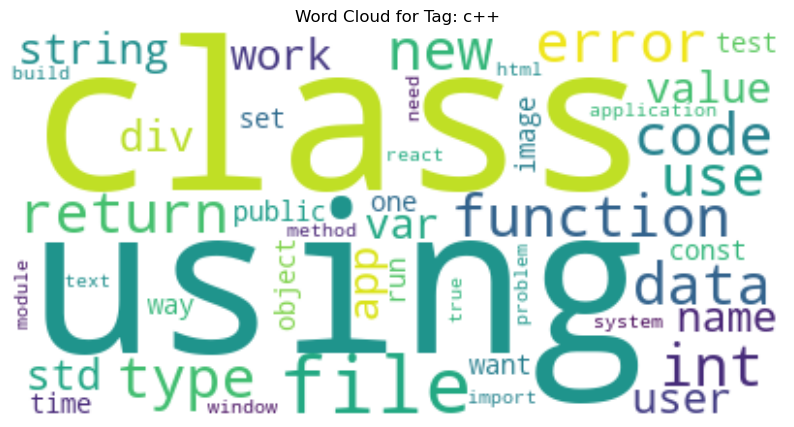

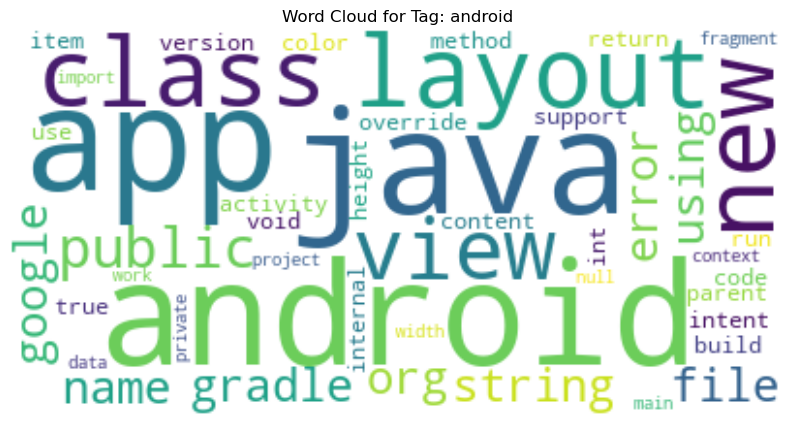

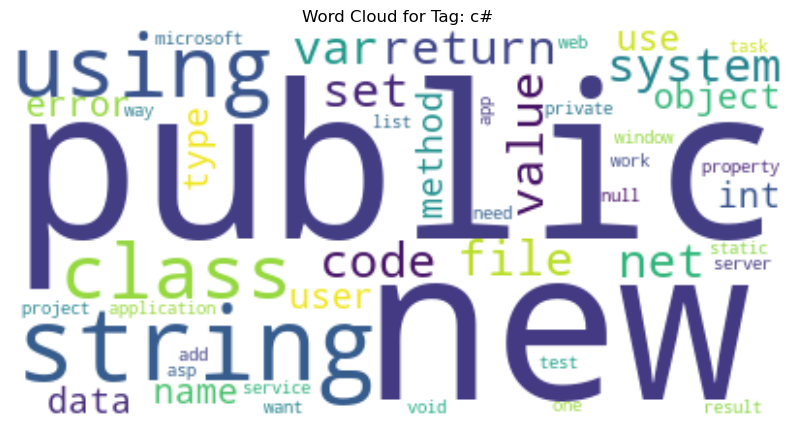

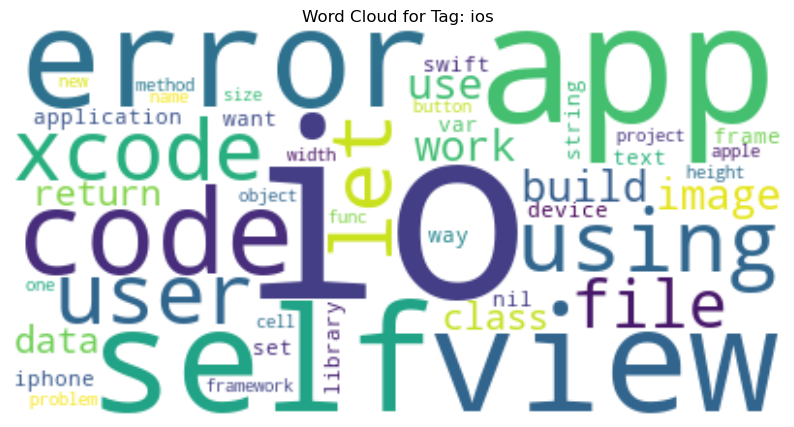

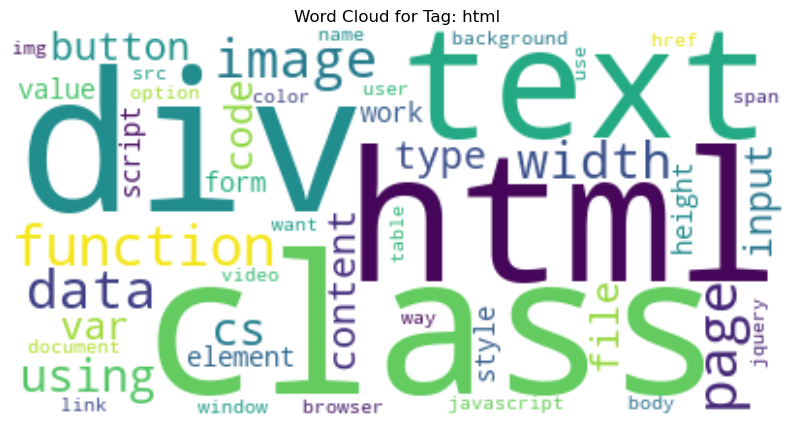

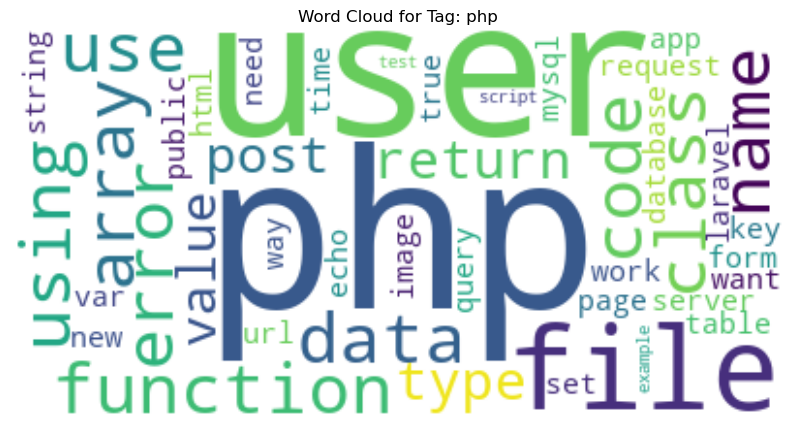

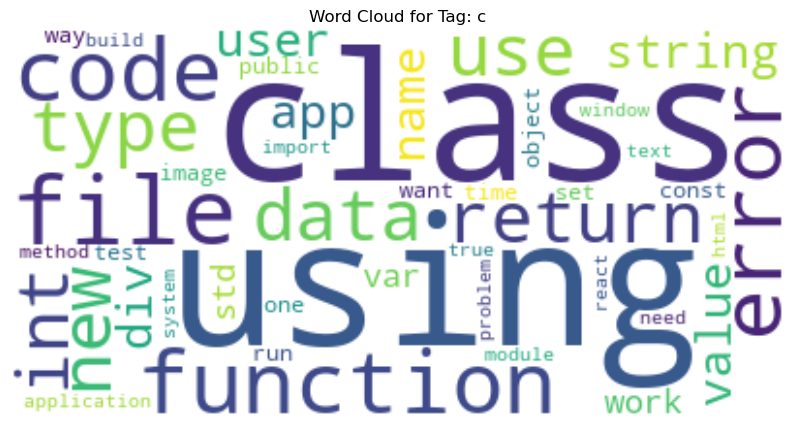

In [278]:
# Générer et afficher le nuage de mots pour chaque tag
for tag, text in tag_data.items():
    # Créer un nuage de mots avec les données associées au tag
    words_only = [mot[0] for mot in text]
    corpus = ' '.join(words_only)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(corpus)
    
    # Afficher le nuage de mots
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Tag: {tag}')
    plt.axis('off')
    plt.show()
    
    # Afficher une ligne vide
    print()

###### Sauvegardage du dataframe final


In [279]:
cleaned_df.to_csv(f'data_final.csv')